## Epidemiology Example

### Packages

In [1]:
# to speed-up execution, mark this as True
USE_CACHED_RESULTS = False
# cross-fold crashes Github CI
USE_CACHED_CV5_RESULTS = True

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import maxent
import maxentep as py0
import tensorflow as tf
tf.get_logger().setLevel('INFO')
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pyabc
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
sns.set_context('paper')
from tqdm import tqdm
from functools import partialmethod

tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

### Set-up SEAIR Model

In [3]:
# Make up some populations (take as known)
M = 3
np.random.seed(0)
population = np.maximum(1000, np.round(np.random.normal(loc=100000, scale=25000, size=(M,)), 0))
area = np.maximum(250, np.round(np.random.normal(loc=2000, scale=1000, size=(M,)), 0))
print(area, population)
population_fraction = population/np.sum(population)

[4241. 3868. 1023.] [144101. 110004. 124468.]


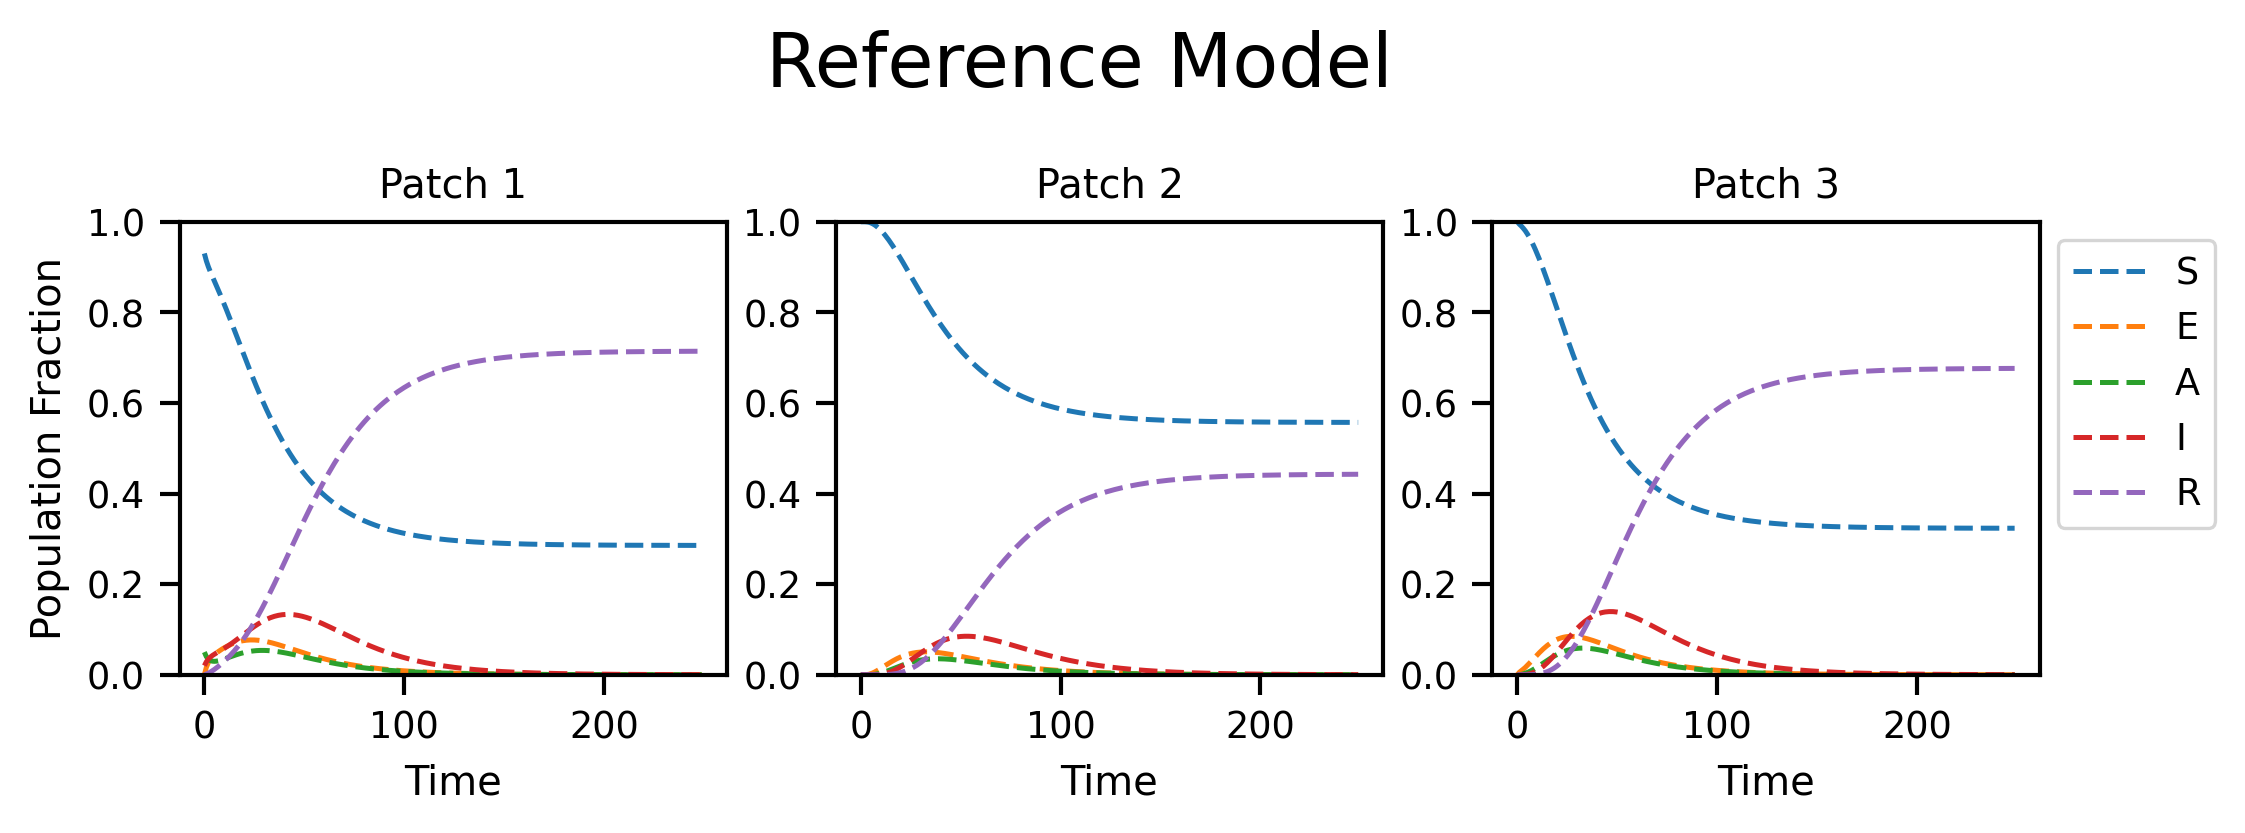

In [6]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
infections_compartments = [1,2]
infect_fxn = py0.contact_infection_func(infections_compartments)
full_compartments = ['S'] + compartments
R = np.array([[1000, 400, 10],
         [0, 300, 300],
         [300, 300, 1000]])
R_norm = R / np.sum(R, axis=1)
def metapop_wraper(start_infected, start_asymptomatic, E_time, A_time, I_time):
    beta = 0.025
    start = np.zeros((3,4))
    start[0,2] = start_infected
    start[0,1] = start_asymptomatic
    tmat = py0.TransitionMatrix(compartments, infections_compartments)
    tmat.add_transition('E', 'A', E_time, 0)
    tmat.add_transition('A', 'I', A_time, 0)
    tmat.add_transition('I', 'R', I_time, 0)
    timesteps = 250
    meta_model = py0.MetaModel(infect_fxn, timesteps, populations=population_fraction)
    trajectory = meta_model(R_norm, tmat.value, start, beta)[0]
    return trajectory
ref_inpputs = [0.02, 0.05, 7, 5, 14]
ref_traj = metapop_wraper(*ref_inpputs)
# ref_traj = ref_traj[np.newaxis,...]
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Reference Model', y = 1.2, fontsize = 18)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1])
    axs[i].plot(ref_traj[:,i],linestyle='--', label=full_compartments)
axs[0].set_ylabel('Population Fraction')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [7]:
npoints = 5
np.random.seed(0)
prior = maxent.Laplace(0.01)
restrained_compartments = [3] #(infected patch)
restrained_compartments_names = [full_compartments[m] for m in restrained_compartments]
number_of_restrained_compartments = len(restrained_compartments) 
restrained_patches = np.array([0])
print ('Patches restrained:', restrained_patches)
print ('Total number of restraints: ', npoints*number_of_restrained_compartments*len(restrained_patches))
print ('Compartments restrained: ', restrained_compartments_names)
restraints, plot_fxns_list = py0.compartment_restrainer(restrained_patches, restrained_compartments, npoints, ref_traj, prior, noise=0.05, start_time=0, end_time = 100)

Patches restrained: [0]
Total number of restraints:  5
Compartments restrained:  ['I']
Restraints are set on this time range: [0, 100]
59 0.11300826 0.10784731813725082
45 0.13207552 0.1526054434665933
31 0.12169184 0.12889401646488136
80 0.06942835 0.1421420223992924
17 0.08018874 0.11824062257689161


In [6]:
ref_traj.shape

TensorShape([250, 3, 5])

### Sample SEAIR Trajectories

In [8]:
tf.random.set_seed(0)
if not USE_CACHED_RESULTS or not os.path.exists('epidemiology_files/maxent_sample_trajs'):
    tmat = py0.TransitionMatrix(compartments, infections_compartments)
    tmat.add_transition('E', 'A', 2, 1)
    tmat.add_transition('A', 'I', 2, 4)
    tmat.add_transition('I', 'R', 10, 5)
    start_logits = np.zeros((M))
    hyper_pram = py0.ParameterHypers()
    hyper_pram.beta_var = 0.000001
    hyper_pram.beta_start = 0.025
    hyper_pram.beta_high = 0.025002
    hyper_pram.beta_low = 0.025001
    hyper_pram.start_mean = 0.001
    hyper_pram.start_high = 0.4
    hyper_pram.start_var = 0.8
    hyper_pram.R_var = 0.00001
    param_model = py0.MetaParameterJoint(start_logits, R, tmat, name='unbiased model', hypers = hyper_pram)
    # Fxing beta and mobility matrix
    R_norm_sample = tf.convert_to_tensor(R_norm)
    beta_sample = tf.convert_to_tensor([0.025])
    N = 2048
    batches = 4
    batch_size = N*batches
    outs = []
    timesteps = 250
    model = py0.MetaModel(infect_fxn, timesteps, populations=population_fraction)
    for b in tqdm(range(batches)):
        psample = param_model.sample(N)
        outs.append(model(*psample))
    trajs = np.concatenate(outs, axis=0)
    np.save('epidemiology_files/maxent_sample_trajs', trajs)
else:
    trajs = np.load('epidemiology_files/maxent_sample_trajs.npy')


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.09s/it]


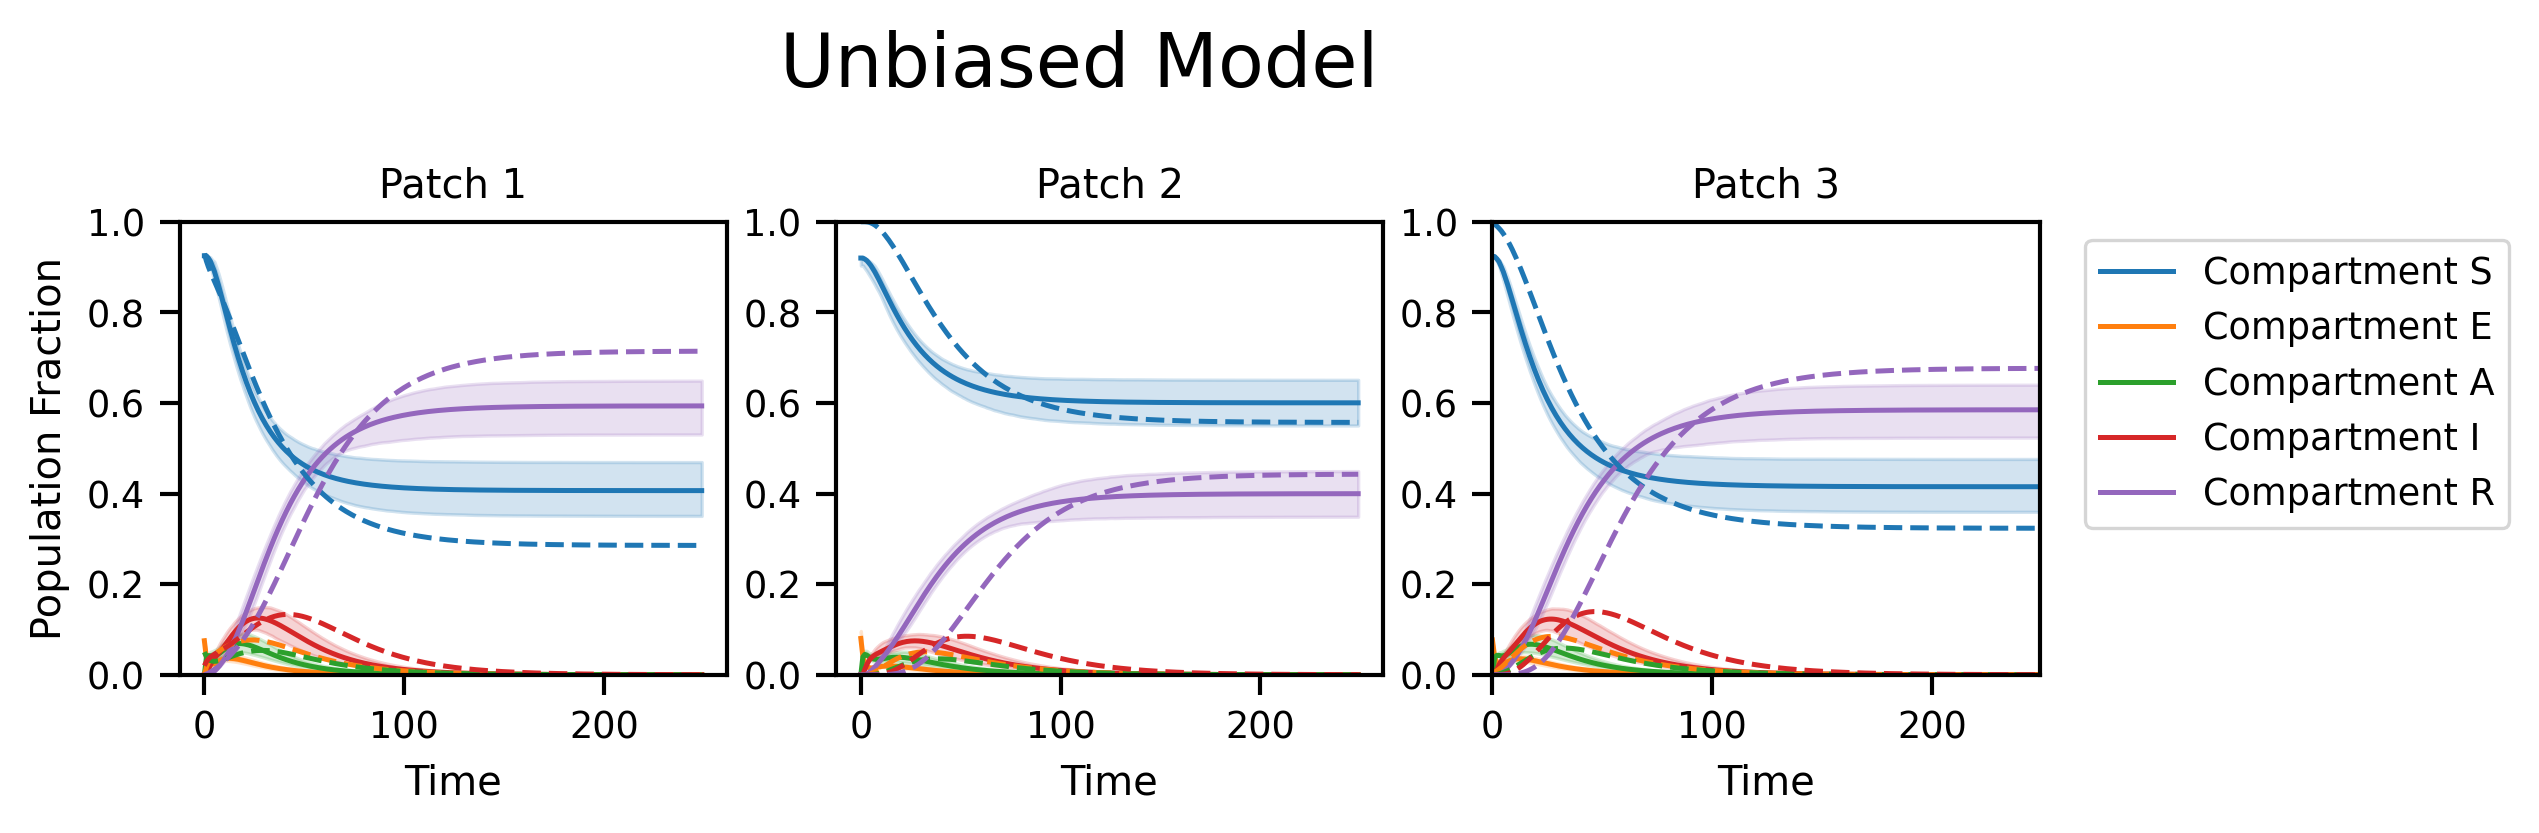

In [10]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Unbiased Model', y = 1.2, fontsize = 18)
py0.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
py0.traj_quantile(trajs[:,:,1,:], names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
py0.traj_quantile(trajs[:,:,2,:], names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
axs[0].set_ylabel('Population Fraction')
plt.show()

In [11]:
if not USE_CACHED_RESULTS:
    me_model = maxent.MaxentModel(restraints)
    me_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-1), 'mean_squared_error')
    me_history = me_model.fit(trajs, batch_size=batch_size,epochs=1000, verbose=0)
    me_w = me_model.traj_weights
    np.save('epidemiology_files/maxent_biased_me_w', me_w)
else:
    me_w = np.load('epidemiology_files/maxent_biased_me_w.npy')

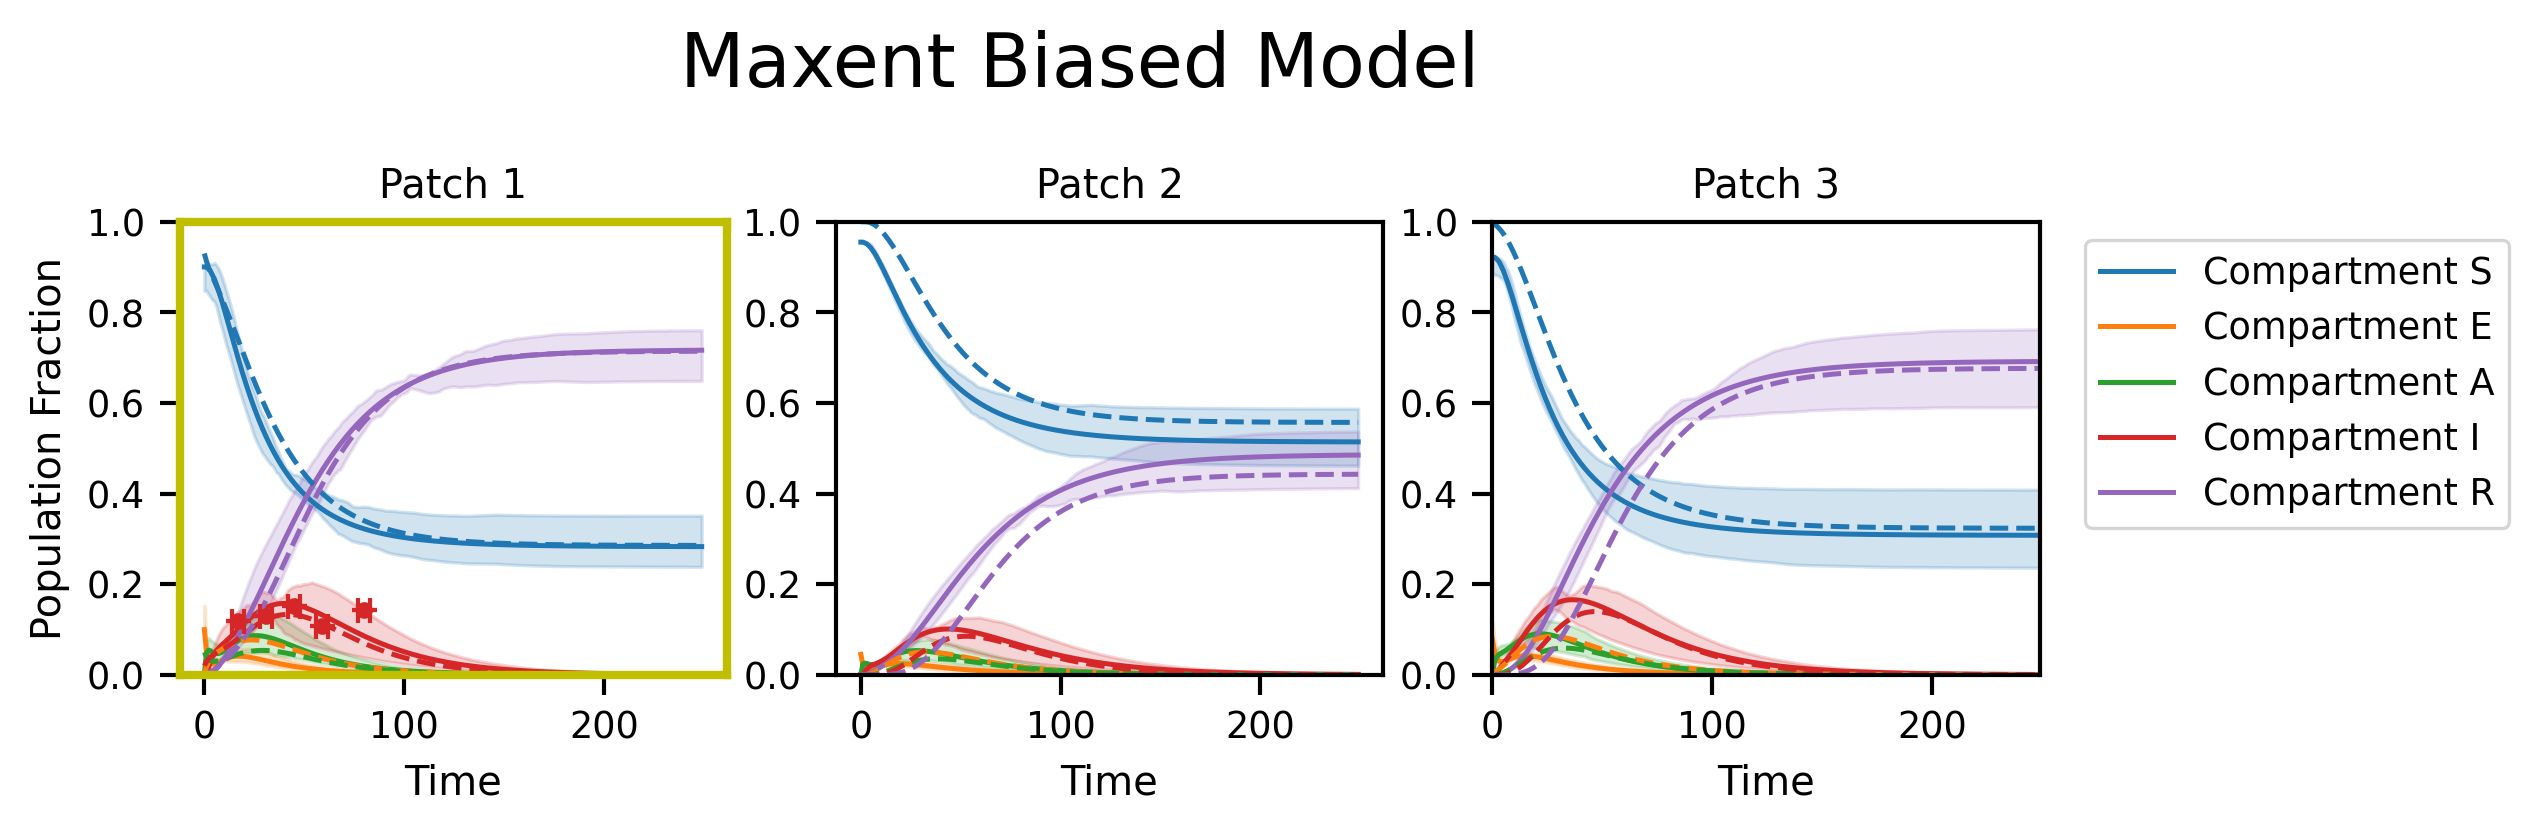

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Maxent Biased Model', y = 1.2, fontsize = 18)
py0.traj_quantile(trajs[:,:,0,:], weights=me_w, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
py0.traj_quantile(trajs[:,:,1,:], weights=me_w, names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
py0.traj_quantile(trajs[:,:,2,:], weights=me_w, names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
    if i in restrained_patches:
        for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i)]):
                pf(axs[i],0, color='C3')
        axs[i].spines['bottom'].set_color('y')
        axs[i].spines['top'].set_color('y') 
        axs[i].spines['right'].set_color('y')
        axs[i].spines['left'].set_color('y')
        axs[i].spines['left'].set_linewidth(2)
        axs[i].spines['top'].set_linewidth(2)
        axs[i].spines['right'].set_linewidth(2)
        axs[i].spines['bottom'].set_linewidth(2)
axs[0].set_ylabel('Population Fraction')
plt.show()

### Least squares regression

In [ ]:
if not USE_CACHED_RESULTS:
    C = len(compartments)
    start = np.zeros((M, C))
    start[0,1] = 0.001
    start[0,2] = 0.001
    beta_start = 0.1
    infect = py0.ContactInfectionLayer(beta_start, infections_compartments)
    # make "agreement" function
    def agreement(traj, rs=restraints):
        s = 0
        for r in rs:
            s += r(traj[0])**2
        return s
    rmodel = py0.TrainableMetaModel(start, R_norm, tmat.value, infect, timesteps, agreement)
    rmodel.compile(optimizer=tf.keras.optimizers.Nadam(0.01))
    utraj = rmodel.get_traj()
    rmodel.fit(timesteps)
    regressed_traj = rmodel.get_traj()
    np.save('epidemiology_files/ls_biased_traj', regressed_traj)
else:
    regressed_traj = np.load('epidemiology_files/ls_biased_traj.npy')

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Least Squares Regression Biased Model', y = 1.2, fontsize = 18)
py0.traj_quantile(regressed_traj[:,:,0,:], names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
py0.traj_quantile(regressed_traj[:,:,1,:], names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
py0.traj_quantile(regressed_traj[:,:,2,:], names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
    if i in restrained_patches:
        for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i)]):
                pf(axs[i],0, color='C3')
        axs[i].spines['bottom'].set_color('y')
        axs[i].spines['top'].set_color('y') 
        axs[i].spines['right'].set_color('y')
        axs[i].spines['left'].set_color('y')
        axs[i].spines['left'].set_linewidth(2)
        axs[i].spines['top'].set_linewidth(2)
        axs[i].spines['right'].set_linewidth(2)
        axs[i].spines['bottom'].set_linewidth(2)
axs[0].set_ylabel('Population Fraction')
plt.show()

### abc

In [ ]:
np.random.seed(0)
start_infected = 0.001
start_asymptomatic = 0.001
E_time = 2
A_time = 2
I_time = 10
abc_param_keys = ['start_infected', 'start_asymptomatic', 'E_time', 'A_time', 'I_time']
abc_param_values = [ start_infected, start_asymptomatic, E_time, A_time, I_time ] 
abc_parameters = dict(zip(abc_param_keys, abc_param_values))

def abc_model(parameter):
    trajectory = metapop_wraper(float(parameter['start_infected']), float(parameter['start_asymptomatic']), \
                               + float(parameter['E_time']), float(parameter['A_time']), float(parameter['I_time'])  )
    restrainted_time_values = [59, 45, 31, 80, 17]
    values = np.array([trajectory[m,0,3].numpy() for m in restrainted_time_values])
    return {'data': values}

def distance(x, y):
    d = np.sum(np.abs(x['data'] - y['data']))
    return(d)
if not USE_CACHED_RESULTS:
    parameter_priors = pyabc.Distribution(
                                    start_infected=pyabc.RV('truncnorm', 0, 0.5, abc_param_values[0], 0.8),
                                    start_asymptomatic=pyabc.RV('truncnorm', 0, 0.5, abc_param_values[1], 0.8),
                                    E_time=pyabc.RV('norm', abc_param_values[2], 1),
                                    A_time=pyabc.RV('norm', abc_param_values[3], 4),
                                    I_time=pyabc.RV('norm', abc_param_values[4], 5))

    abc = pyabc.ABCSMC(abc_model, parameter_priors, distance)
    db_path = 'sqlite:///' + os.path.join(os.getcwd(), 'abc_SEAIR.db') 
    observation = np.array([r.target for r in restraints])
    abc.new(db_path, {'data': observation})
    history = abc.run(minimum_epsilon=0.1, max_nr_populations=5)
    df, w_abc = history.get_distribution(m=0, t=history.max_t)
    abc_trajs=np.empty((len(df), ref_traj.shape[0], ref_traj.shape[1], ref_traj.shape[2]))
    for i, row in enumerate(tqdm(np.array(df))):
        A_time_abc, E_time_abc, I_time_abc, start_asymptomatic_abc, start_infected_abc= row[0], row[1], row[2], row[3], row[4]
        traj = metapop_wraper(start_infected_abc, start_asymptomatic_abc, E_time_abc,A_time_abc, I_time_abc)
        abc_trajs[i] = traj
    abc_biased_traj = np.sum(abc_trajs * w_abc[:, np.newaxis, np.newaxis, np.newaxis], axis = 0)
    np.save('epidemiology_files/abc_biased_traj.npy', abc_biased_traj)
else:
    abc_biased_traj = np.load('epidemiology_files/abc_biased_traj.npy')

### 5-fold cross validation

In [ ]:
if not USE_CACHED_CV5_RESULTS:
    LS_traj_folds = np.empty((npoints,trajs.shape[1],trajs.shape[2],trajs.shape[-1]))
    MaxEnt_traj_folds = np.empty_like(LS_traj_folds)
    abc_traj_folds = []
    for i in range(npoints):
        sampled_restraints = [n for n in restraints if n != restraints[i]]
        ## MaxEnt
        print(f'Initializing LS for fold {i}')
        def new_agreement(traj, rs=sampled_restraints):
            s = 0
            for r in rs:
                s += r(traj[0])**2
            return s
        rmodel_sampled = py0.TrainableMetaModel(start, R_norm, tmat.value, infect, timesteps, new_agreement)
        rmodel_sampled.compile(optimizer=tf.keras.optimizers.Nadam(0.01))
        utraj_sampled = rmodel_sampled.get_traj()
        rmodel_sampled.fit(timesteps)
        regressed_traj_sampled = rmodel_sampled.get_traj()
        LS_traj_folds[i,:,:,:] = regressed_traj_sampled
        ## MaxEnt
        print(f'Initializing MaxEnt for fold {i}')
        me_model_sample = py0.MaxentModel(sampled_restraints, trajs=trajs, population_fraction=population_fraction)
        me_model_sample.compile(tf.keras.optimizers.Adam(learning_rate=1e-1), 'mean_squared_error')
        me_history_sample = me_model_sample.fit(trajs, batch_size=batch_size, epochs=1000)
        MaxEnt_traj_folds[i,:,:,:] = np.sum(me_model_sample.trajs * me_model_sample.traj_weights[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
        ## ABC
        print(f'Initializing ABC for fold {i}')
        def abc_model(parameter):
            trajectory = metapop_wraper(float(parameter['start_infected']), float(parameter['start_asymptomatic']),
                                        + float(parameter['E_time']), float(parameter['A_time']), float(parameter['I_time']))
            restrainted_time_values = [59, 45, 31, 80, 17]
            restrainted_time_values.pop(i)
            values = np.array([trajectory[m, 0, 3].numpy()
                               for m in restrainted_time_values])
            return {'data': values}
        parameter_priors = pyabc.Distribution(
                                        start_infected=pyabc.RV('truncnorm', 0, 0.5, abc_param_values[0], 0.8),
                                        start_asymptomatic=pyabc.RV('truncnorm', 0, 0.5, abc_param_values[1], 0.8),
                                        E_time=pyabc.RV('norm', abc_param_values[2], 1),
                                        A_time=pyabc.RV('norm', abc_param_values[3], 4),
                                        I_time=pyabc.RV('norm', abc_param_values[4], 5))

        abc = pyabc.ABCSMC(abc_model, parameter_priors, distance)
        db_path = 'sqlite:///' + os.path.join(os.getcwd(), 'abc_SEAIR.db')
        observation_abc = np.array([r.target for r in sampled_restraints])
        abc.new(db_path, {'data': observation_abc})
        history = abc.run(minimum_epsilon=0.1, max_nr_populations=5)
        df, w_abc = history.get_distribution(m=0, t=history.max_t)
        abc_trajs = np.empty(
            (len(df), ref_traj.shape[0], ref_traj.shape[1], ref_traj.shape[2]))
        for j, row in enumerate(tqdm(np.array(df))):
            A_time_abc, E_time_abc, I_time_abc, start_asymptomatic_abc, start_infected_abc = row[
                0], row[1], row[2], row[3], row[4]
            traj = metapop_wraper(
                abs(start_infected_abc), abs(start_asymptomatic_abc), E_time_abc, A_time_abc, I_time_abc)
            abc_trajs[j] = traj
        mean_abc_traj = np.sum(
                abc_trajs * w_abc[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
        abc_traj_folds.append(mean_abc_traj)
    np.save('epidemiology_files/abc_traj_folds.npy', abc_traj_folds)
    np.save('epidemiology_files/MaxEnt_traj_folds.npy', MaxEnt_traj_folds)
    np.save('epidemiology_files/LS_traj_folds.npy', LS_traj_folds)
abc_traj_folds = np.load('epidemiology_files/abc_traj_folds.npy')
MaxEnt_traj_folds = np.load('epidemiology_files/MaxEnt_traj_folds.npy')
LS_traj_folds = np.load('epidemiology_files/LS_traj_folds.npy')

In [ ]:
def find_std(sample_trajs):
    std_0 = np.std(sample_trajs[:,0,2,4])
    std_mid = np.std(sample_trajs[:,125,2,4])
    std_end = np.std(sample_trajs[:,-1,2,4])
    return [std_0, std_mid, std_end]
    
std_abc = find_std(abc_traj_folds)
std_MaxEnt = find_std(MaxEnt_traj_folds)
std_LS = find_std(LS_traj_folds)
print('MaxEnt std : ', std_MaxEnt)
print('Least-squares std : ', std_LS)
print('ABC std : ', std_abc)


In [ ]:
def weighted_quantile(values, quantiles, sample_weight=None,
                       values_sorted=False, old_style=False):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

In [ ]:
new_stds = np.array(np.round([std_MaxEnt, std_LS, std_abc],3))
def set_align_for_column(table, col, align="left"):
    cells = [key for key in table._cells if key[1] == col]
    for cell in cells:
        table._cells[cell]._loc = align
        
plt.rc('axes', titlesize=8)
from matplotlib.font_manager import FontProperties
sns.set_context('paper')
sns.set_style('darkgrid',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#333333', 'ytick.color': '#333333'})
plt.rcParams["mathtext.fontset"] = "dejavuserif"
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']


import matplotlib.markers as mmark
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.9
plt.rcParams['grid.color'] = "#cccccc"
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(11,3.5), dpi =300, gridspec_kw={'width_ratios': [5,5,2.5]})

py0.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True, ax =axs[0], add_legend= True, alpha = 0.2)
axs[0].plot(ref_traj[:,0],linestyle='--')
axs[0].set_ylabel('Population Fraction')
plt.setp(axs[0], xlabel='Time', title = 'a) Patch 1', xlim =[0, 250], ylim =[0, 1.0], facecolor ='white' )
for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(0)]):
                pf(axs[0],0, color='black')
Reference_line = plt.Line2D((0,1),(0,0), color='k', linestyle='--')
rs_marker = plt.Line2D((0,1),(0,0), color='k', marker='o',linestyle='', ms=3)
hand, labl = axs[0].get_legend_handles_labels()
Reference_label = 'Reference model'
Restraints_label = 'Restraints'
axs[0].legend([handle for i,handle in enumerate(hand)]+[Reference_line,rs_marker],
              [label for i,label in enumerate(labl)]+[Reference_label,Restraints_label]
                , bbox_to_anchor=(1.02,0.7), fontsize=8, frameon=True, fancybox=True, facecolor='white')


plt.setp(axs[1], xlabel='Time', title = 'b) Compartment R in Patch 3', xlim =[0, 250], ylim =[0, 1.0], facecolor ='white' )
w = np.ones(trajs.shape[0])
w /=np.sum(w)
mtrajs_unbiased = np.sum(trajs * w[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
mtrajs_maxentbiased = np.sum(trajs * me_w[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
mtrajs_regressedbiased = np.sum(regressed_traj, axis=0)
x = range(trajs.shape[1])
qtrajs_maxentbiased = np.apply_along_axis(lambda x: weighted_quantile(
    x, [1/3, 1/2, 2/3], sample_weight=me_w), 0, trajs)
qtrajs_maxentbiased[0, :, :] = np.clip(
            qtrajs_maxentbiased[0, :, :] - qtrajs_maxentbiased[1, :, :] + mtrajs_maxentbiased, 0, 1)
qtrajs_maxentbiased[2, :, :] = np.clip(
            qtrajs_maxentbiased[2, :, :] - qtrajs_maxentbiased[1, :, :] + mtrajs_maxentbiased, 0, 1)
qtrajs_maxentbiased[1, :, :] = mtrajs_maxentbiased
print(mtrajs_unbiased.shape)

axs[1].plot(x, mtrajs_unbiased[:,2,4], color= '#4a8c76',  label='Unbiased')
axs[1].plot(x, mtrajs_maxentbiased[:,2,4], color= '#D03D9A',  label='MaxEnt')
axs[1].plot(x, abc_biased_traj[:,2,4], color= '#fcec03')
axs[1].plot(ref_traj[:,2,4],linestyle='--', color= 'k')
axs[1].fill_between(x, qtrajs_maxentbiased[0, :, 2, 4],qtrajs_maxentbiased[-1, :, 2, 4],
                        color='#D03D9A', alpha=0.2)
axs[1].plot(x, mtrajs_regressedbiased[:,2,4], color= '#35a9d4')
axs[1].legend(bbox_to_anchor=(0.45,0.38), fontsize=6)
hand, labl = axs[1].get_legend_handles_labels()
predicted_label_LS = 'Least-squares'
predicted_line_LS = plt.Line2D((0,1),(0,0), color='#35a9d4')
predicted_label_abc = 'ABC'
predicted_line_abc = plt.Line2D((0,1),(0,0), color='#fcec03')
ref_label = 'Reference model'
ref_line = plt.Line2D((0,1),(0,0), color='k', linestyle='--')
axs[1].legend([handle for i,handle in enumerate(hand)] + [predicted_line_LS, predicted_line_abc, ref_line] ,
              [label for i,label in enumerate(labl)] + [predicted_label_LS, predicted_label_abc, ref_label ]
                , bbox_to_anchor=(1.6,0.67), fontsize=8, frameon=True, fancybox=True, facecolor='white')

collabel=("$\sigma_{t=0}$","$\sigma_{t=125}$", "$\sigma_{t=250}$")
axs[2].axis('tight')
axs[2].axis('off')
tb = axs[2].table(cellText=np.round(new_stds,3),colLabels=collabel, rowLabels=['MaxEnt', 'Least-squares', 'ABC'],
                         loc='center', cellLoc='center', rowLoc='center' ,colWidths=[0.2 for x in collabel],fontsize=12,
                  edges='BRTL' , bbox=[-0.38,0.19,0.65,0.45], alpha=0.35)

for (row, col), cell in tb.get_celld().items():
    if (row == 0) or (col == -1):
        cell.set_text_props(fontproperties=FontProperties(weight='bold'))

for key, cell in tb.get_celld().items():
    cell.set_linewidth(0.8)
    cell.set_edgecolor("#545350")
    cell.set_facecolor("white")
    cell.set_alpha(0.9)
    
set_align_for_column(tb, col=0, align="center")
set_align_for_column(tb, col=1, align="center")
plt.tight_layout()
plt.subplots_adjust(wspace=0.9)
axs[2].set_position([0.652,0.041,0.15,0.7])


### Variational Inference

In [33]:
fit_param_model = py0.MetaParameterJoint(start_logits, R, tmat, name='unbiased_model',hypers = hyper_pram)
fit_param_model.compile(tf.optimizers.Adam(0.1))
hme_model = maxent.HyperMaxentModel(restraints, fit_param_model, model, reweight=False)
hme_model.compile(tf.keras.optimizers.Adam(learning_rate=0.1), 'mean_squared_error')

In [34]:
hme_history = hme_model.fit(
    N, final_batch_multiplier=batches, 
    outter_epochs=3, param_epochs=250, batch_size=batch_size//4, epochs=1000, verbose=0)

In [35]:
#hme_final_history = hme_model.fit(N, final_batch_multiplier=batches, outter_epochs=1, batch_size=batch_size, epochs=1000, verbose=0)

Text(0.5, 1.0, 'neg log-likelihood')

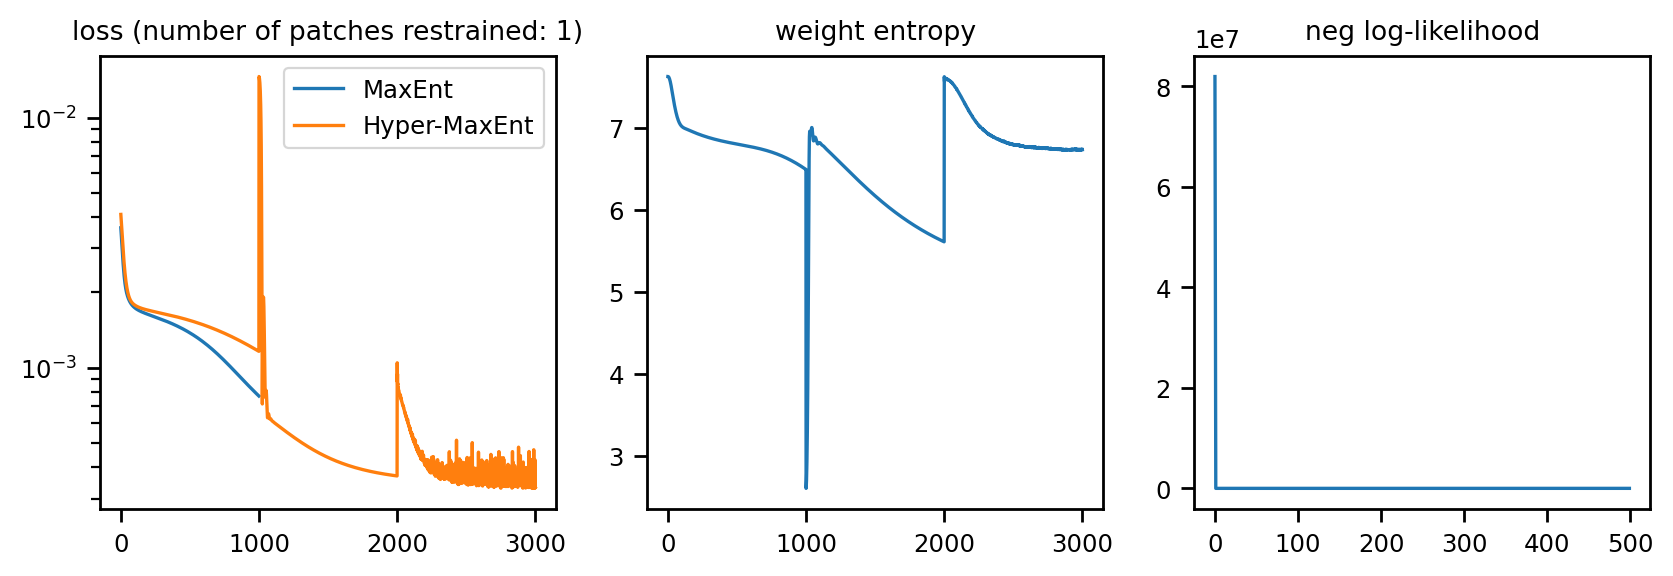

In [36]:
fig, ax = plt.subplots(1,3,figsize=(10,3),dpi=200)
ax[0].plot(me_history.history['loss'],label='MaxEnt')
ax[0].plot(hme_history.history['loss'],label='Hyper-MaxEnt')
ax[0].set_title('loss (number of patches restrained: {})'.format(len(restrained_patches)))
ax[0].set_yscale('log')
ax[0].legend()

ax[1].plot(hme_history.history['weight-entropy'])
ax[1].set_title('weight entropy')

ax[2].plot(hme_history.history['prior-loss'])
ax[2].set_title('neg log-likelihood')

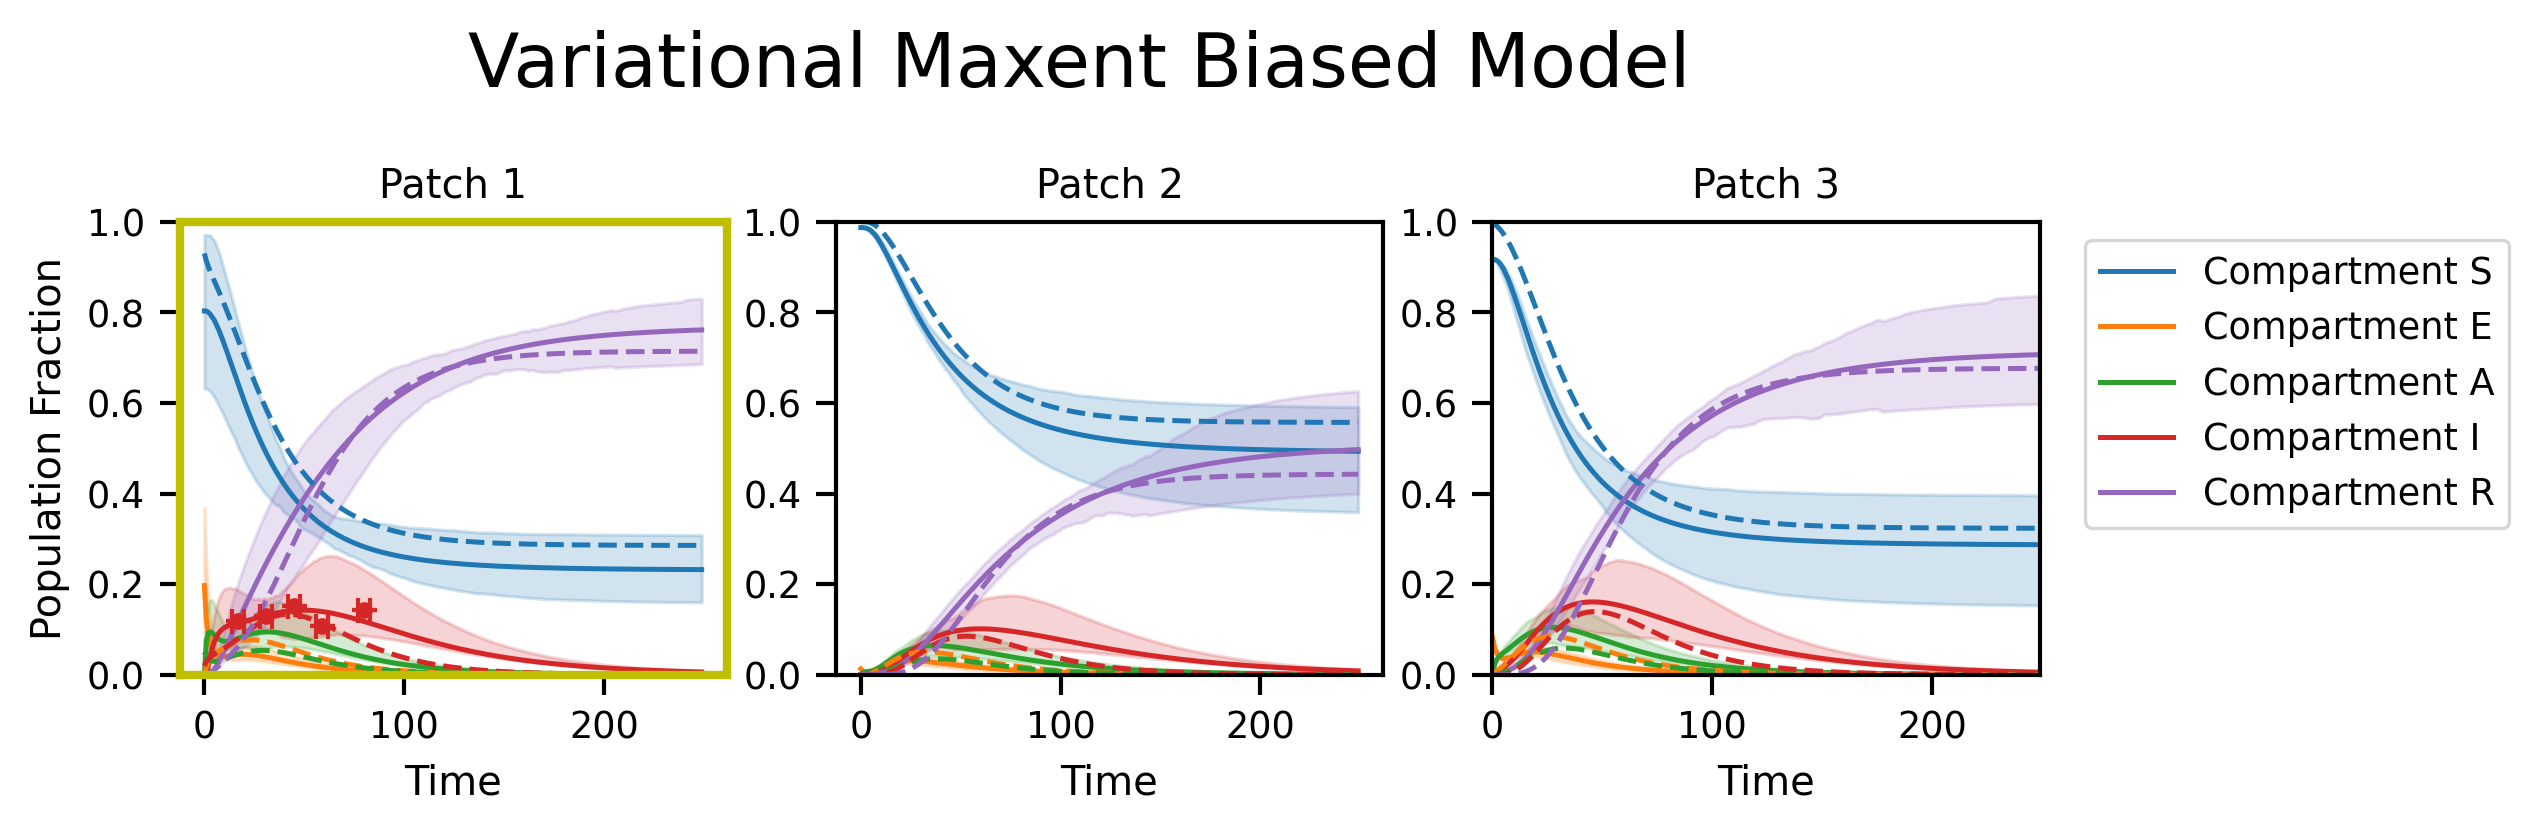

In [38]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Variational Maxent Biased Model', y = 1.2, fontsize = 18)
py0.traj_quantile(hme_model.trajs[:,:,0,:], weights=hme_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
py0.traj_quantile(hme_model.trajs[:,:,1,:], weights=hme_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
py0.traj_quantile(hme_model.trajs[:,:,2,:], weights=hme_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
    if i in restrained_patches:
        for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i)]):
                pf(axs[i],0, color='C3')
        axs[i].spines['bottom'].set_color('y')
        axs[i].spines['top'].set_color('y') 
        axs[i].spines['right'].set_color('y')
        axs[i].spines['left'].set_color('y')
        axs[i].spines['left'].set_linewidth(2)
        axs[i].spines['top'].set_linewidth(2)
        axs[i].spines['right'].set_linewidth(2)
        axs[i].spines['bottom'].set_linewidth(2)
axs[0].set_ylabel('Population Fraction')
plt.savefig('varitional_maxent.svg', dpi=600)